# Load Data

In [45]:
import load_data
df = load_data.load_county_level(data_dir='data')
keys = df.keys()

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [46]:
import numpy as np
import torch as th
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
for i in range(87, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
for i in range(218, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 96471 #fixed the population value for Erie

temp_cases = []
for i in range(168, 216):
    temp_cases.append(np.array(df[keys[i]]))
temp_cases = np.stack(temp_cases, 1)

temp_deaths = []
for i in range(299, 347):
    temp_deaths.append(np.array(df[keys[i]]))
temp_deaths = np.stack(temp_deaths, 1)

In [47]:
keys = df.keys()
for i, val in enumerate(df.iloc[4]):
    print(i, '\t', keys[i], '\t', val)

0 	 countyFIPS 	 36061
1 	 STATEFP 	 36.0
2 	 COUNTYFP 	 61.0
3 	 CountyName 	 New York
4 	 StateName 	 NY
5 	 State 	 New York
6 	 lat 	 40.77021579
7 	 lon 	 -73.97427095
8 	 POP_LATITUDE 	 40.777958
9 	 POP_LONGITUDE 	 -73.966303
10 	 CensusRegionName 	 Northeast
11 	 CensusDivisionName 	 Middle Atlantic
12 	 Rural-UrbanContinuumCode2013 	 1.0
13 	 PopulationEstimate2018 	 1628701.0
14 	 PopTotalMale2017 	 789070.0
15 	 PopTotalFemale2017 	 875657.0
16 	 FracMale2017 	 0.473993633791006
17 	 PopulationEstimate65+2017 	 266384.0
18 	 PopulationDensityperSqMile2010 	 69468.4
19 	 CensusPopulation2010 	 1585873.0
20 	 MedianAge2010 	 36.4
21 	 #EligibleforMedicare2018 	 295301.0
22 	 MedicareEnrollment,AgedTot2017 	 245044.0
23 	 3-YrDiabetes2015-17 	 272.0
24 	 DiabetesPercentage 	 6.5
25 	 HeartDiseaseMortality 	 143.5
26 	 StrokeMortality 	 18.9
27 	 Smokers_Percentage 	 12.41823421
28 	 RespMortalityRate2014 	 23.47
29 	 #FTEHospitalTotal2017 	 100758.0
30 	 TotalM.D.'s,TotNon-Feda

In [86]:
import random
randm_lst = [random.randint(40,80) for i in range(6)]

In [87]:
randm_lst

[70, 80, 51, 59, 79, 53]

In [48]:
import torch as th

out_size = 1
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
# number of days for input
in_len = 20
# number of days for output
out_len = 1

train_past_cases_1d = []
train_past_deaths_1d = []
train_labels_cases_1d = []
train_labels_deaths_1d = []
for start in range(train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    train_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    train_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))

valid_past_cases_1d = []
valid_past_deaths_1d = []
valid_labels_cases_1d = []
valid_labels_deaths_1d = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    valid_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    valid_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    valid_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    
test_past_cases_1d = []
test_past_deaths_1d = []
test_labels_cases_1d = []
test_labels_deaths_1d = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    test_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    test_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    test_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))

In [49]:
train_labels_Sacramento = []
for i in range(19,79):
    train_labels_Sacramento.append(train_labels_cases_1d[i][202].cpu().numpy())

train_labels_NYC = []
for i in range(19,79):
    train_labels_NYC.append(train_labels_cases_1d[i][4].cpu().numpy())

# Models

## MLP - SIR

In [50]:
import torch.nn as nn

class Net_SIR(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(Net_SIR, self).__init__()
        self.nn_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.nn_model(x)

# Helper Functions

In [51]:
def my_msle(output, target):
    loss = th.mean(((output.add(1)).log() - (target.add(1)).log())**2)
    return loss

In [52]:
def my_msle_ID(I, D, I_label, D_label):
    I_loss = ((I.add(1)).log() - (I_label.add(1)).log())**2
    D_loss = ((D.add(1)).log() - (D_label.add(1)).log())**2
    loss = th.mean(th.add(I_loss, D_loss))
    return loss

In [53]:
def sir_1d_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D

    I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
    D_new = th.add(D, th.mul(gamma.view(3142,1), I))

    return I_new, D_new

## GAT - SIR

### Contiguous Graph

In [54]:
import numpy as np

county_names = df['CountyName']
county_code = np.array([int(code) for code in df['countyFIPS']])
county_code_dict = {code:idx for idx, code in enumerate(county_code)}

In [55]:
import pandas as pd
data_contiguous = pd.read_csv('/home/ubuntu/covid19-severity-prediction/data/neighborcounties.csv')
df_contiguous = pd.DataFrame(data_contiguous, columns= ['orgfips','adjfips','instate'])

In [56]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(len(county_code_dict))
for ind in df_contiguous.index: 
    src = int(df_contiguous['orgfips'][ind])
    dst = int(df_contiguous['adjfips'][ind])
    if src in county_code_dict and dst in county_code_dict:
        g.add_edge(county_code_dict[src],county_code_dict[dst])

In [57]:
from dgl.nn import pytorch as dglnn
import torch.nn.functional as F
import torch.nn as nn

class GAT_SIR(nn.Module):
    def __init__(self, g, input_size, hidden_size, output_size, gcn_nlayers, num_heads=5):
        super(GAT_SIR, self).__init__()
        self.g = g
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(dglnn.conv.GATConv(input_size, hidden_size, num_heads=num_heads,
                                                  residual=True, activation=F.relu))
        for i in range(gcn_nlayers):
            self.gcn_layers.append(dglnn.conv.GATConv(num_heads * hidden_size, hidden_size, num_heads=num_heads,
                                                      residual=True, activation=F.relu))

        self.linear_layers = nn.Sequential(
            nn.Linear(num_heads * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = x
        for layer in self.gcn_layers:
            h = layer(self.g, h).flatten(1)
        return self.linear_layers(h)

# Training

## MLP - SIR

In [58]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
        # print('epoch={}, loss={:.3f}, test loss={:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))
            
#        old_eval_err = new_eval_err
#        new_eval_err = np.mean(eval_errs)
#        if old_eval_err <= new_eval_err:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                I_new, D_new = sir_1d_output(vals, I, D)
#                train_vals.append(I_new)
#            break
    # print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97
epoch=0, loss=1.027, validation loss = 2.251, test loss=2.148, test mse = 7605734.500, test mae = 373.769
epoch=1, loss=0.874, validation loss = 1.529, test loss=1.652, test mse = 26493.605, test mae = 48.367
epoch=2, loss=0.822, validation loss = 1.485, test loss=1.603, test mse = 4662.581, test mae = 22.186
epoch=3, loss=0.814, validation loss = 1.460, test loss=1.573, test mse = 2481.027, test mae = 13.992
epoch=4, loss=0.808, validation loss = 1.440, test loss=1.549, test mse = 1995.214, test mae = 9.702
epoch=5, loss=0.802, validation loss = 1.422, test loss=1.527, test mse = 1866.670, test mae = 7.940
epoch=6, loss=0.797, validation loss = 1.406, test loss=1.507, test mse = 1857.722, test mae = 8.296
epoch=7, loss=0.791, validation loss = 1.390, test loss=1.488, test mse = 1889.952, test mae = 9.295
epoch=8, loss=0.786, validation loss = 1.374, test loss=1.469, test mse = 1933.056, test mae = 10.326
epoch=9, loss=0.781, validation loss = 1.359, test loss=1.451, test

epoch=80, loss=0.502, validation loss = 0.641, test loss=0.602, test mse = 1650.995, test mae = 10.795
epoch=81, loss=0.499, validation loss = 0.635, test loss=0.595, test mse = 1649.343, test mae = 10.753
epoch=82, loss=0.496, validation loss = 0.628, test loss=0.588, test mse = 1647.754, test mae = 10.712
epoch=83, loss=0.494, validation loss = 0.622, test loss=0.581, test mse = 1646.224, test mae = 10.671
epoch=84, loss=0.491, validation loss = 0.616, test loss=0.574, test mse = 1644.746, test mae = 10.632
epoch=85, loss=0.488, validation loss = 0.609, test loss=0.567, test mse = 1643.326, test mae = 10.594
epoch=86, loss=0.485, validation loss = 0.603, test loss=0.561, test mse = 1641.953, test mae = 10.557
epoch=87, loss=0.482, validation loss = 0.597, test loss=0.554, test mse = 1640.628, test mae = 10.520
epoch=88, loss=0.480, validation loss = 0.591, test loss=0.548, test mse = 1639.349, test mae = 10.485
epoch=89, loss=0.477, validation loss = 0.585, test loss=0.541, test mse 

epoch=160, loss=0.317, validation loss = 0.280, test loss=0.233, test mse = 1600.891, test mae = 8.994
epoch=161, loss=0.315, validation loss = 0.277, test loss=0.230, test mse = 1600.684, test mae = 8.980
epoch=162, loss=0.313, validation loss = 0.274, test loss=0.227, test mse = 1600.480, test mae = 8.965
epoch=163, loss=0.311, validation loss = 0.272, test loss=0.225, test mse = 1600.280, test mae = 8.951
epoch=164, loss=0.309, validation loss = 0.269, test loss=0.222, test mse = 1600.083, test mae = 8.937
epoch=165, loss=0.308, validation loss = 0.266, test loss=0.220, test mse = 1599.890, test mae = 8.923
epoch=166, loss=0.306, validation loss = 0.263, test loss=0.217, test mse = 1599.700, test mae = 8.910
epoch=167, loss=0.304, validation loss = 0.261, test loss=0.215, test mse = 1599.513, test mae = 8.896
epoch=168, loss=0.303, validation loss = 0.258, test loss=0.212, test mse = 1599.330, test mae = 8.882
epoch=169, loss=0.301, validation loss = 0.255, test loss=0.210, test mse

epoch=240, loss=0.210, validation loss = 0.135, test loss=0.105, test mse = 1591.413, test mae = 8.050
epoch=241, loss=0.209, validation loss = 0.134, test loss=0.105, test mse = 1591.352, test mae = 8.041
epoch=242, loss=0.208, validation loss = 0.133, test loss=0.104, test mse = 1591.291, test mae = 8.031
epoch=243, loss=0.208, validation loss = 0.132, test loss=0.103, test mse = 1591.231, test mae = 8.022
epoch=244, loss=0.207, validation loss = 0.131, test loss=0.102, test mse = 1591.172, test mae = 8.013
epoch=245, loss=0.206, validation loss = 0.130, test loss=0.101, test mse = 1591.114, test mae = 8.003
epoch=246, loss=0.205, validation loss = 0.130, test loss=0.101, test mse = 1591.056, test mae = 7.994
epoch=247, loss=0.204, validation loss = 0.129, test loss=0.100, test mse = 1591.000, test mae = 7.985
epoch=248, loss=0.203, validation loss = 0.128, test loss=0.099, test mse = 1590.944, test mae = 7.976
epoch=249, loss=0.202, validation loss = 0.127, test loss=0.099, test mse

epoch=320, loss=0.166, validation loss = 0.091, test loss=0.070, test mse = 1588.590, test mae = 7.437
epoch=321, loss=0.166, validation loss = 0.091, test loss=0.070, test mse = 1588.575, test mae = 7.432
epoch=322, loss=0.166, validation loss = 0.090, test loss=0.070, test mse = 1588.559, test mae = 7.426
epoch=323, loss=0.165, validation loss = 0.090, test loss=0.070, test mse = 1588.544, test mae = 7.420
epoch=324, loss=0.165, validation loss = 0.090, test loss=0.069, test mse = 1588.529, test mae = 7.415
epoch=325, loss=0.165, validation loss = 0.090, test loss=0.069, test mse = 1588.514, test mae = 7.409
epoch=326, loss=0.165, validation loss = 0.090, test loss=0.069, test mse = 1588.500, test mae = 7.403
epoch=327, loss=0.164, validation loss = 0.089, test loss=0.069, test mse = 1588.486, test mae = 7.398
epoch=328, loss=0.164, validation loss = 0.089, test loss=0.069, test mse = 1588.472, test mae = 7.392
epoch=329, loss=0.164, validation loss = 0.089, test loss=0.068, test mse

epoch=400, loss=0.157, validation loss = 0.080, test loss=0.061, test mse = 1588.006, test mae = 7.113
epoch=401, loss=0.157, validation loss = 0.080, test loss=0.061, test mse = 1588.004, test mae = 7.110
epoch=402, loss=0.157, validation loss = 0.080, test loss=0.061, test mse = 1588.002, test mae = 7.108
epoch=403, loss=0.157, validation loss = 0.079, test loss=0.061, test mse = 1588.000, test mae = 7.105
epoch=404, loss=0.157, validation loss = 0.079, test loss=0.061, test mse = 1587.999, test mae = 7.103
epoch=405, loss=0.157, validation loss = 0.079, test loss=0.061, test mse = 1587.997, test mae = 7.101
epoch=406, loss=0.157, validation loss = 0.079, test loss=0.061, test mse = 1587.995, test mae = 7.098
epoch=407, loss=0.157, validation loss = 0.079, test loss=0.061, test mse = 1587.994, test mae = 7.096
epoch=408, loss=0.157, validation loss = 0.079, test loss=0.060, test mse = 1587.992, test mae = 7.094
epoch=409, loss=0.157, validation loss = 0.079, test loss=0.060, test mse

epoch=480, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.969, test mae = 6.985
epoch=481, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.969, test mae = 6.984
epoch=482, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.970, test mae = 6.983
epoch=483, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.970, test mae = 6.982
epoch=484, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.970, test mae = 6.981
epoch=485, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.970, test mae = 6.980
epoch=486, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.970, test mae = 6.979
epoch=487, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.971, test mae = 6.978
epoch=488, loss=0.156, validation loss = 0.076, test loss=0.058, test mse = 1587.971, test mae = 6.977
epoch=489, loss=0.156, validation loss = 0.076, test loss=0.058, test mse

epoch=560, loss=0.156, validation loss = 0.075, test loss=0.057, test mse = 1587.988, test mae = 6.937
epoch=561, loss=0.156, validation loss = 0.075, test loss=0.057, test mse = 1587.988, test mae = 6.936
epoch=562, loss=0.156, validation loss = 0.075, test loss=0.057, test mse = 1587.988, test mae = 6.936
epoch=563, loss=0.157, validation loss = 0.075, test loss=0.057, test mse = 1587.988, test mae = 6.936
epoch=564, loss=0.157, validation loss = 0.075, test loss=0.057, test mse = 1587.988, test mae = 6.935
epoch=565, loss=0.157, validation loss = 0.075, test loss=0.057, test mse = 1587.988, test mae = 6.935
epoch=566, loss=0.157, validation loss = 0.075, test loss=0.057, test mse = 1587.989, test mae = 6.935
epoch=567, loss=0.157, validation loss = 0.075, test loss=0.057, test mse = 1587.989, test mae = 6.934
epoch=568, loss=0.157, validation loss = 0.075, test loss=0.057, test mse = 1587.989, test mae = 6.934
epoch=569, loss=0.157, validation loss = 0.075, test loss=0.057, test mse

epoch=640, loss=0.157, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.922
epoch=641, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.922
epoch=642, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.922
epoch=643, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.922
epoch=644, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.922
epoch=645, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.922
epoch=646, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.921
epoch=647, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.921
epoch=648, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.996, test mae = 6.921
epoch=649, loss=0.158, validation loss = 0.075, test loss=0.057, test mse

epoch=720, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=721, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=722, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=723, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=724, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=725, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=726, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=727, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=728, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.998, test mae = 6.918
epoch=729, loss=0.158, validation loss = 0.075, test loss=0.057, test mse

epoch=800, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=801, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=802, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=803, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=804, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=805, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=806, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=807, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=808, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=809, loss=0.158, validation loss = 0.075, test loss=0.057, test mse

epoch=880, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=881, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=882, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=883, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=884, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=885, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=886, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=887, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=888, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=889, loss=0.158, validation loss = 0.075, test loss=0.057, test mse

epoch=960, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=961, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=962, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=963, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=964, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=965, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=966, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=967, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=968, loss=0.158, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=969, loss=0.158, validation loss = 0.075, test loss=0.057, test mse

In [59]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(19, len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

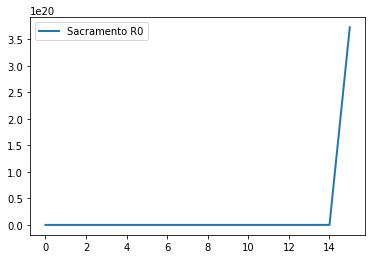

In [60]:
import PIL
import matplotlib.pyplot as plt

x = range(60)
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

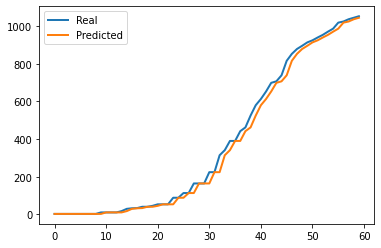

In [61]:
pred_vals = []
for i in range(79-19):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(60)
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

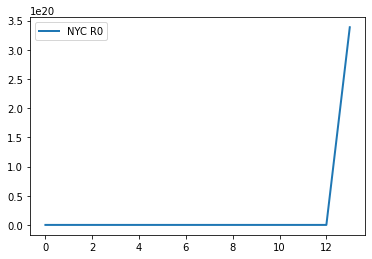

In [62]:
x = range(60)
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

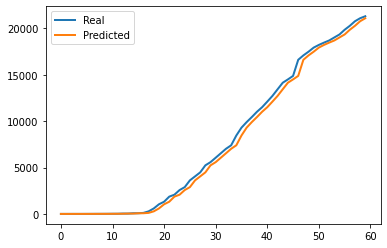

In [63]:
pred_vals_NYC = []
for i in range(79-19):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(60)
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

## GAT - SIR

In [64]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
        

            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
#        old_eval_err = new_eval_err
#        new_eval_err = np.mean(eval_errs)
#        if old_eval_err <= new_eval_err:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][0])
#                beta_Sacramento.append(vals[202][0])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                I_new, D_new = sir_1d_output(vals, I, D)
#                train_vals.append(I_new)
#            break
#    print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97
epoch=0, loss=0.420, validation loss = 0.541, test loss=0.462, test mse = 972424.812, test mae = 33.520
epoch=1, loss=0.308, validation loss = 0.307, test loss=0.223, test mse = 1596.626, test mae = 7.423
epoch=2, loss=0.267, validation loss = 0.232, test loss=0.169, test mse = 1590.130, test mae = 7.139
epoch=3, loss=0.241, validation loss = 0.189, test loss=0.138, test mse = 1589.931, test mae = 7.098
epoch=4, loss=0.222, validation loss = 0.162, test loss=0.118, test mse = 1590.290, test mae = 7.112
epoch=5, loss=0.208, validation loss = 0.142, test loss=0.104, test mse = 1591.048, test mae = 7.139
epoch=6, loss=0.197, validation loss = 0.128, test loss=0.094, test mse = 1591.889, test mae = 7.161
epoch=7, loss=0.188, validation loss = 0.118, test loss=0.087, test mse = 1592.355, test mae = 7.173
epoch=8, loss=0.180, validation loss = 0.110, test loss=0.081, test mse = 1592.947, test mae = 7.173
epoch=9, loss=0.174, validation loss = 0.104, test loss=0.077, test mse = 

epoch=81, loss=0.119, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.920
epoch=82, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.920
epoch=83, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.920
epoch=84, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.920
epoch=85, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.920
epoch=86, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.920
epoch=87, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.919
epoch=88, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.919
epoch=89, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.997, test mae = 6.919
epoch=90, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.99

epoch=161, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=162, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=163, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=164, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=165, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=166, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=167, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=168, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=169, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=170, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=241, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=242, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=243, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=244, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=245, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=246, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=247, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=248, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=249, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=250, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=321, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=322, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=323, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=324, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=325, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=326, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=327, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=328, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=329, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=330, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=401, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=402, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=403, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=404, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=405, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=406, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=407, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=408, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=409, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=410, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=481, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=482, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=483, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=484, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=485, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=486, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=487, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=488, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=489, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=490, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=561, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=562, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=563, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=564, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=565, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=566, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=567, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=568, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=569, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=570, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=641, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=642, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=643, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=644, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=645, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=646, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=647, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=648, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=649, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=650, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=721, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=722, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=723, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=724, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=725, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=726, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=727, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=728, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=729, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=730, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=801, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=802, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=803, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=804, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=805, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=806, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=807, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=808, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=809, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=810, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=881, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=882, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=883, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=884, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=885, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=886, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=887, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=888, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=889, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=890, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

epoch=961, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=962, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=963, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=964, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=965, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=966, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=967, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=968, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=969, loss=0.120, validation loss = 0.075, test loss=0.057, test mse = 1587.999, test mae = 6.918
epoch=970, loss=0.120, validation loss = 0.075, test loss=0.057, test mse

In [65]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(19, len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

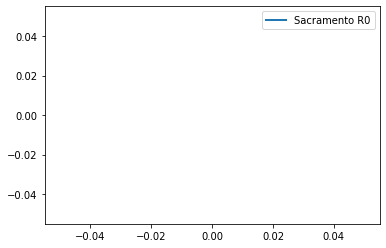

In [66]:
import PIL
import matplotlib.pyplot as plt

x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

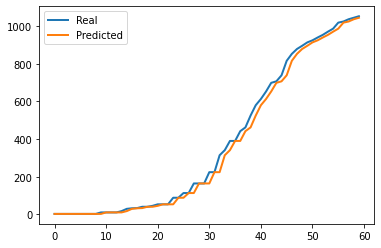

In [67]:
pred_vals = []
for i in range(79-19):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(60)
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

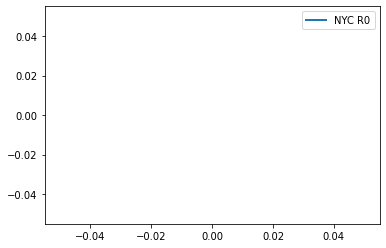

In [68]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

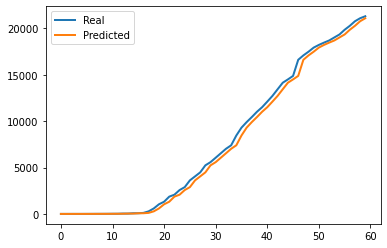

In [69]:
pred_vals_NYC = []
for i in range(79-19):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(60)
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

# 7-day Predictions

## Prepare Data

In [70]:
import numpy as np
import torch as th
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
for i in range(87, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
for i in range(218, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 1 

print('attrs:', attrs.shape)
print('cases:', cases.shape)
print('deaths:', deaths.shape)
print(attrs[0])
print(cases[0])
print(deaths[0])

attrs: torch.Size([3142, 78])
cases: (3142, 129)
deaths: (3142, 129)
tensor([ 4.0641e+01, -7.3955e+01,  4.0651e+01, -7.3955e+01,  1.0000e+00,
         2.5828e+06,  1.2550e+06,  1.3938e+06,  4.7379e-01,  3.5671e+05,
         3.5369e+04,  2.5047e+06,  3.4100e+01,  3.8667e+05,  3.0966e+05,
         6.3500e+02,  9.7000e+00,  1.9580e+02,  1.9500e+01,  1.3841e+01,
         2.3050e+01,  3.5442e+04,  9.3070e+03,  6.0000e+00,  1.2000e+01,
         3.1800e+02,  4.5415e+00,  9.0415e+04,  8.6783e+04,  8.1356e+04,
         7.8035e+04,  7.9604e+04,  7.6959e+04,  8.6716e+04,  8.3968e+04,
         9.6663e+04,  9.9134e+04,  1.0605e+05,  1.1679e+05,  9.7154e+04,
         1.0570e+05,  1.6196e+05,  1.7958e+05,  1.4949e+05,  1.7469e+05,
         6.3789e+04,  7.8116e+04,  5.5241e+04,  6.8866e+04,  6.4628e+04,
         8.8066e+04,  3.5780e+04,  5.8209e+04,  1.2524e+04,  2.8426e+04,
         1.5400e+02,  2.4000e+01,  3.3000e+01,  1.5100e+02,  3.4100e+02,
         4.9300e+02,  1.1160e+03,  2.1390e+03,  2.8520e

In [71]:
import torch as th

num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 7
out_size = 7

train_past_cases = []
train_past_deaths = []
train_labels_cases = []
train_labels_deaths = []
for start in range(train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))

valid_past_cases = []
valid_past_deaths = []
valid_labels_cases = []
valid_labels_deaths = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    valid_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    valid_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    valid_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    
test_past_cases = []
test_past_deaths = []
test_labels_cases = []
test_labels_deaths = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    test_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    test_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    test_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))

## Helper Functions

In [72]:
def sir_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D
    I_lst = []
    D_lst = []
    for i in range(7):
        S_new = th.add(S, - th.div(th.mul(beta.view(3142,1), th.mul(S, I)), pop))
        I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
        D_new = th.add(D, th.mul(gamma.view(3142,1), I))
        I_lst.append(I_new)
        D_lst.append(D_new)
        S = S_new
        I = I_new
        D = D_new
    return th.cat(I_lst, dim = 1), th.cat(D_lst, dim = 1)

## Training Loop

### MLP - SIR

In [73]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
            
#        if np.mean(eval_errs) <= 0.054:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                output = sir_output(vals, I, D, labels)
#                train_vals.append(output)
#            break
#        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=2.149, validation loss = 5.889, test loss=6.940, test mse = 7388500.500, test mae = 411.195
epoch=1, loss=2.075, validation loss = 5.107, test loss=4.968, test mse = 5009922.500, test mae = 334.835
epoch=2, loss=1.967, validation loss = 3.804, test loss=3.810, test mse = 1413424.125, test mae = 129.554
epoch=3, loss=1.899, validation loss = 3.403, test loss=3.639, test mse = 4340843.000, test mae = 108.572
epoch=4, loss=1.898, validation loss = 3.354, test loss=3.601, test mse = 7224761.500, test mae = 114.052
epoch=5, loss=1.899, validation loss = 3.340, test loss=3.587, test mse = 8793877.000, test mae = 130.850
epoch=6, loss=1.899, validation loss = 3.333, test loss=3.579, test mse = 9233785.000, test mae = 144.255
epoch=7, loss=1.897, validation loss = 3.326, test loss=3.570, test mse = 9049546.000, test mae = 150.745
epoch=8, loss=1.894, validation loss = 3.317, test loss=3.559, test mse = 8409229.000, test mae = 151.058
epoch=9, loss=1.889, validation 

epoch=79, loss=1.567, validation loss = 2.442, test loss=2.421, test mse = 30222.945, test mae = 29.964
epoch=80, loss=1.564, validation loss = 2.433, test loss=2.408, test mse = 30222.906, test mae = 29.959
epoch=81, loss=1.561, validation loss = 2.423, test loss=2.396, test mse = 30222.846, test mae = 29.952
epoch=82, loss=1.558, validation loss = 2.413, test loss=2.384, test mse = 30222.775, test mae = 29.945
epoch=83, loss=1.555, validation loss = 2.403, test loss=2.372, test mse = 30222.689, test mae = 29.938
epoch=84, loss=1.551, validation loss = 2.394, test loss=2.360, test mse = 30222.592, test mae = 29.929
epoch=85, loss=1.548, validation loss = 2.384, test loss=2.347, test mse = 30222.486, test mae = 29.921
epoch=86, loss=1.545, validation loss = 2.374, test loss=2.335, test mse = 30222.365, test mae = 29.911
epoch=87, loss=1.542, validation loss = 2.364, test loss=2.323, test mse = 30222.236, test mae = 29.902
epoch=88, loss=1.539, validation loss = 2.355, test loss=2.311, 

epoch=158, loss=1.317, validation loss = 1.719, test loss=1.552, test mse = 30217.674, test mae = 29.273
epoch=159, loss=1.314, validation loss = 1.711, test loss=1.543, test mse = 30217.771, test mae = 29.273
epoch=160, loss=1.311, validation loss = 1.703, test loss=1.534, test mse = 30217.867, test mae = 29.273
epoch=161, loss=1.308, validation loss = 1.695, test loss=1.524, test mse = 30217.959, test mae = 29.273
epoch=162, loss=1.305, validation loss = 1.686, test loss=1.515, test mse = 30218.049, test mae = 29.273
epoch=163, loss=1.301, validation loss = 1.678, test loss=1.506, test mse = 30218.141, test mae = 29.273
epoch=164, loss=1.298, validation loss = 1.670, test loss=1.496, test mse = 30218.225, test mae = 29.273
epoch=165, loss=1.295, validation loss = 1.662, test loss=1.487, test mse = 30218.305, test mae = 29.272
epoch=166, loss=1.292, validation loss = 1.654, test loss=1.478, test mse = 30218.385, test mae = 29.272
epoch=167, loss=1.289, validation loss = 1.646, test lo

epoch=237, loss=1.069, validation loss = 1.106, test loss=0.879, test mse = 30218.469, test mae = 28.917
epoch=238, loss=1.066, validation loss = 1.099, test loss=0.872, test mse = 30218.463, test mae = 28.911
epoch=239, loss=1.063, validation loss = 1.093, test loss=0.865, test mse = 30218.463, test mae = 28.905
epoch=240, loss=1.060, validation loss = 1.086, test loss=0.858, test mse = 30218.461, test mae = 28.900
epoch=241, loss=1.057, validation loss = 1.079, test loss=0.851, test mse = 30218.461, test mae = 28.894
epoch=242, loss=1.054, validation loss = 1.072, test loss=0.844, test mse = 30218.463, test mae = 28.889
epoch=243, loss=1.051, validation loss = 1.065, test loss=0.837, test mse = 30218.463, test mae = 28.884
epoch=244, loss=1.048, validation loss = 1.059, test loss=0.830, test mse = 30218.467, test mae = 28.879
epoch=245, loss=1.044, validation loss = 1.052, test loss=0.823, test mse = 30218.471, test mae = 28.873
epoch=246, loss=1.041, validation loss = 1.045, test lo

epoch=316, loss=0.844, validation loss = 0.657, test loss=0.448, test mse = 30219.330, test mae = 28.639
epoch=317, loss=0.842, validation loss = 0.653, test loss=0.444, test mse = 30219.346, test mae = 28.636
epoch=318, loss=0.840, validation loss = 0.649, test loss=0.441, test mse = 30219.354, test mae = 28.633
epoch=319, loss=0.837, validation loss = 0.645, test loss=0.437, test mse = 30219.365, test mae = 28.631
epoch=320, loss=0.835, validation loss = 0.641, test loss=0.434, test mse = 30219.377, test mae = 28.628
epoch=321, loss=0.833, validation loss = 0.637, test loss=0.431, test mse = 30219.389, test mae = 28.625
epoch=322, loss=0.831, validation loss = 0.633, test loss=0.427, test mse = 30219.398, test mae = 28.623
epoch=323, loss=0.829, validation loss = 0.630, test loss=0.424, test mse = 30219.406, test mae = 28.620
epoch=324, loss=0.826, validation loss = 0.626, test loss=0.421, test mse = 30219.420, test mae = 28.618
epoch=325, loss=0.824, validation loss = 0.622, test lo

epoch=395, loss=0.740, validation loss = 0.472, test loss=0.293, test mse = 30220.039, test mae = 28.482
epoch=396, loss=0.740, validation loss = 0.471, test loss=0.292, test mse = 30220.049, test mae = 28.481
epoch=397, loss=0.740, validation loss = 0.471, test loss=0.291, test mse = 30220.055, test mae = 28.479
epoch=398, loss=0.739, validation loss = 0.470, test loss=0.290, test mse = 30220.061, test mae = 28.478
epoch=399, loss=0.739, validation loss = 0.469, test loss=0.290, test mse = 30220.068, test mae = 28.477
epoch=400, loss=0.739, validation loss = 0.468, test loss=0.289, test mse = 30220.070, test mae = 28.476
epoch=401, loss=0.739, validation loss = 0.467, test loss=0.288, test mse = 30220.084, test mae = 28.475
epoch=402, loss=0.738, validation loss = 0.466, test loss=0.288, test mse = 30220.086, test mae = 28.473
epoch=403, loss=0.738, validation loss = 0.465, test loss=0.287, test mse = 30220.094, test mae = 28.472
epoch=404, loss=0.738, validation loss = 0.465, test lo

epoch=474, loss=0.757, validation loss = 0.444, test loss=0.268, test mse = 30220.447, test mae = 28.425
epoch=475, loss=0.758, validation loss = 0.444, test loss=0.268, test mse = 30220.447, test mae = 28.425
epoch=476, loss=0.758, validation loss = 0.444, test loss=0.268, test mse = 30220.453, test mae = 28.424
epoch=477, loss=0.759, validation loss = 0.444, test loss=0.268, test mse = 30220.453, test mae = 28.424
epoch=478, loss=0.759, validation loss = 0.444, test loss=0.267, test mse = 30220.459, test mae = 28.424
epoch=479, loss=0.760, validation loss = 0.444, test loss=0.267, test mse = 30220.463, test mae = 28.423
epoch=480, loss=0.760, validation loss = 0.444, test loss=0.267, test mse = 30220.467, test mae = 28.423
epoch=481, loss=0.761, validation loss = 0.444, test loss=0.267, test mse = 30220.467, test mae = 28.423
epoch=482, loss=0.761, validation loss = 0.444, test loss=0.267, test mse = 30220.471, test mae = 28.422
epoch=483, loss=0.762, validation loss = 0.444, test lo

epoch=553, loss=0.790, validation loss = 0.446, test loss=0.267, test mse = 30220.609, test mae = 28.409
epoch=554, loss=0.790, validation loss = 0.446, test loss=0.267, test mse = 30220.609, test mae = 28.409
epoch=555, loss=0.791, validation loss = 0.446, test loss=0.267, test mse = 30220.609, test mae = 28.408
epoch=556, loss=0.791, validation loss = 0.446, test loss=0.267, test mse = 30220.611, test mae = 28.408
epoch=557, loss=0.791, validation loss = 0.446, test loss=0.268, test mse = 30220.617, test mae = 28.408
epoch=558, loss=0.792, validation loss = 0.446, test loss=0.268, test mse = 30220.617, test mae = 28.408
epoch=559, loss=0.792, validation loss = 0.446, test loss=0.268, test mse = 30220.617, test mae = 28.408
epoch=560, loss=0.792, validation loss = 0.446, test loss=0.268, test mse = 30220.617, test mae = 28.408
epoch=561, loss=0.792, validation loss = 0.446, test loss=0.268, test mse = 30220.619, test mae = 28.408
epoch=562, loss=0.793, validation loss = 0.446, test lo

epoch=632, loss=0.805, validation loss = 0.448, test loss=0.268, test mse = 30220.662, test mae = 28.403
epoch=633, loss=0.805, validation loss = 0.448, test loss=0.268, test mse = 30220.662, test mae = 28.403
epoch=634, loss=0.806, validation loss = 0.448, test loss=0.268, test mse = 30220.662, test mae = 28.403
epoch=635, loss=0.806, validation loss = 0.448, test loss=0.269, test mse = 30220.662, test mae = 28.403
epoch=636, loss=0.806, validation loss = 0.448, test loss=0.269, test mse = 30220.662, test mae = 28.403
epoch=637, loss=0.806, validation loss = 0.448, test loss=0.269, test mse = 30220.664, test mae = 28.403
epoch=638, loss=0.806, validation loss = 0.448, test loss=0.269, test mse = 30220.664, test mae = 28.403
epoch=639, loss=0.806, validation loss = 0.448, test loss=0.269, test mse = 30220.664, test mae = 28.403
epoch=640, loss=0.806, validation loss = 0.448, test loss=0.269, test mse = 30220.664, test mae = 28.402
epoch=641, loss=0.806, validation loss = 0.448, test lo

epoch=711, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=712, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=713, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=714, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=715, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=716, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=717, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=718, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=719, loss=0.811, validation loss = 0.449, test loss=0.269, test mse = 30220.678, test mae = 28.401
epoch=720, loss=0.812, validation loss = 0.449, test lo

epoch=790, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=791, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=792, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=793, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=794, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=795, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=796, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=797, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=798, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=799, loss=0.813, validation loss = 0.449, test lo

epoch=869, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=870, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=871, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=872, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=873, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=874, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=875, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=876, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=877, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=878, loss=0.814, validation loss = 0.449, test lo

epoch=948, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=949, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=950, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=951, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=952, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=953, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=954, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=955, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=956, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=957, loss=0.814, validation loss = 0.449, test lo

In [74]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(19, len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

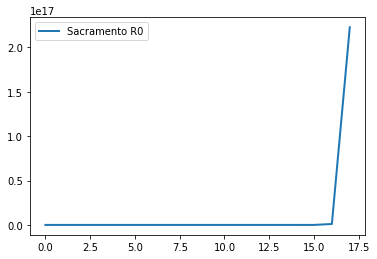

In [75]:
x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

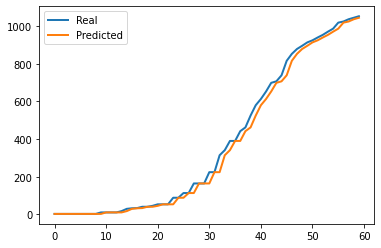

In [76]:
pred_vals = []
for i in range(79-19):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(60)
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

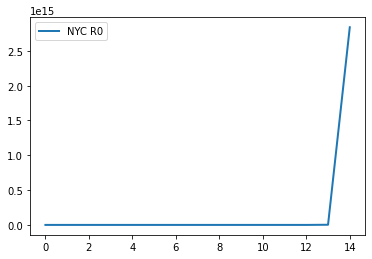

In [77]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

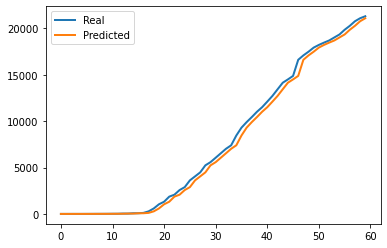

In [78]:
pred_vals_NYC = []
for i in range(79-19):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(60)
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

### GAT - SIR

In [79]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
            
#        if np.mean(eval_errs) <= 0.054:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                output = sir_output(vals, I, D, labels)
#                train_vals.append(output)
#            break
#        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=1.690, validation loss = 2.150, test loss=2.006, test mse = 2003408.375, test mae = 83.629
epoch=1, loss=1.410, validation loss = 1.490, test loss=1.109, test mse = 30867.297, test mae = 32.314
epoch=2, loss=1.306, validation loss = 1.270, test loss=0.871, test mse = 31777.047, test mae = 30.509
epoch=3, loss=1.244, validation loss = 1.149, test loss=0.755, test mse = 34032.730, test mae = 30.074
epoch=4, loss=1.199, validation loss = 1.063, test loss=0.679, test mse = 33057.445, test mae = 29.788
epoch=5, loss=1.163, validation loss = 0.998, test loss=0.624, test mse = 32951.785, test mae = 29.593
epoch=6, loss=1.133, validation loss = 0.939, test loss=0.579, test mse = 32495.305, test mae = 29.340
epoch=7, loss=1.107, validation loss = 0.891, test loss=0.543, test mse = 30801.697, test mae = 29.056
epoch=8, loss=1.084, validation loss = 0.848, test loss=0.512, test mse = 30297.115, test mae = 28.870
epoch=9, loss=1.064, validation loss = 0.809, test loss=0

epoch=79, loss=0.782, validation loss = 0.451, test loss=0.270, test mse = 30220.658, test mae = 28.407
epoch=80, loss=0.781, validation loss = 0.451, test loss=0.270, test mse = 30220.658, test mae = 28.407
epoch=81, loss=0.781, validation loss = 0.451, test loss=0.270, test mse = 30220.658, test mae = 28.407
epoch=82, loss=0.781, validation loss = 0.450, test loss=0.270, test mse = 30220.658, test mae = 28.406
epoch=83, loss=0.781, validation loss = 0.450, test loss=0.270, test mse = 30220.662, test mae = 28.406
epoch=84, loss=0.781, validation loss = 0.450, test loss=0.270, test mse = 30220.662, test mae = 28.406
epoch=85, loss=0.781, validation loss = 0.450, test loss=0.270, test mse = 30220.662, test mae = 28.406
epoch=86, loss=0.781, validation loss = 0.450, test loss=0.270, test mse = 30220.662, test mae = 28.406
epoch=87, loss=0.781, validation loss = 0.450, test loss=0.270, test mse = 30220.662, test mae = 28.406
epoch=88, loss=0.781, validation loss = 0.450, test loss=0.270, 

epoch=158, loss=0.781, validation loss = 0.450, test loss=0.269, test mse = 30220.672, test mae = 28.410
epoch=159, loss=0.781, validation loss = 0.450, test loss=0.269, test mse = 30220.672, test mae = 28.410
epoch=160, loss=0.781, validation loss = 0.450, test loss=0.269, test mse = 30220.672, test mae = 28.411
epoch=161, loss=0.780, validation loss = 0.450, test loss=0.269, test mse = 30220.680, test mae = 28.412
epoch=162, loss=0.780, validation loss = 0.450, test loss=0.270, test mse = 30220.680, test mae = 28.412
epoch=163, loss=0.779, validation loss = 0.450, test loss=0.270, test mse = 30220.680, test mae = 28.413
epoch=164, loss=0.779, validation loss = 0.450, test loss=0.270, test mse = 30220.680, test mae = 28.414
epoch=165, loss=0.778, validation loss = 0.450, test loss=0.270, test mse = 30220.680, test mae = 28.415
epoch=166, loss=0.778, validation loss = 0.450, test loss=0.270, test mse = 30220.682, test mae = 28.415
epoch=167, loss=0.778, validation loss = 0.450, test lo

epoch=237, loss=0.765, validation loss = 0.447, test loss=0.269, test mse = 30220.648, test mae = 28.408
epoch=238, loss=0.764, validation loss = 0.448, test loss=0.269, test mse = 30220.646, test mae = 28.409
epoch=239, loss=0.762, validation loss = 0.449, test loss=0.269, test mse = 30220.641, test mae = 28.411
epoch=240, loss=0.764, validation loss = 0.450, test loss=0.269, test mse = 30220.635, test mae = 28.412
epoch=241, loss=0.766, validation loss = 0.451, test loss=0.269, test mse = 30220.641, test mae = 28.413
epoch=242, loss=0.766, validation loss = 0.451, test loss=0.269, test mse = 30220.633, test mae = 28.413
epoch=243, loss=0.763, validation loss = 0.449, test loss=0.269, test mse = 30220.639, test mae = 28.411
epoch=244, loss=0.761, validation loss = 0.448, test loss=0.269, test mse = 30220.641, test mae = 28.410
epoch=245, loss=0.762, validation loss = 0.447, test loss=0.269, test mse = 30220.646, test mae = 28.409
epoch=246, loss=0.764, validation loss = 0.447, test lo

epoch=316, loss=0.773, validation loss = 0.448, test loss=0.269, test mse = 30220.578, test mae = 28.410
epoch=317, loss=0.770, validation loss = 0.448, test loss=0.269, test mse = 30220.518, test mae = 28.412
epoch=318, loss=0.767, validation loss = 0.448, test loss=0.269, test mse = 30220.369, test mae = 28.415
epoch=319, loss=0.764, validation loss = 0.448, test loss=0.270, test mse = 30219.938, test mae = 28.418
epoch=320, loss=0.762, validation loss = 0.449, test loss=0.270, test mse = 30218.814, test mae = 28.417
epoch=321, loss=0.767, validation loss = 0.455, test loss=0.271, test mse = 30219.799, test mae = 28.432
epoch=322, loss=0.783, validation loss = 0.459, test loss=0.272, test mse = 30223.920, test mae = 28.446
epoch=323, loss=0.766, validation loss = 0.449, test loss=0.270, test mse = 30218.584, test mae = 28.417
epoch=324, loss=0.761, validation loss = 0.448, test loss=0.270, test mse = 30219.945, test mae = 28.418
epoch=325, loss=0.764, validation loss = 0.448, test lo

epoch=395, loss=0.780, validation loss = 0.448, test loss=0.269, test mse = 30220.650, test mae = 28.404
epoch=396, loss=0.778, validation loss = 0.448, test loss=0.269, test mse = 30220.648, test mae = 28.405
epoch=397, loss=0.775, validation loss = 0.448, test loss=0.269, test mse = 30220.641, test mae = 28.407
epoch=398, loss=0.772, validation loss = 0.448, test loss=0.269, test mse = 30220.627, test mae = 28.409
epoch=399, loss=0.768, validation loss = 0.448, test loss=0.269, test mse = 30220.592, test mae = 28.412
epoch=400, loss=0.763, validation loss = 0.448, test loss=0.269, test mse = 30220.492, test mae = 28.418
epoch=401, loss=0.762, validation loss = 0.448, test loss=0.270, test mse = 30220.096, test mae = 28.425
epoch=402, loss=0.778, validation loss = 0.452, test loss=0.271, test mse = 30219.475, test mae = 28.432
epoch=403, loss=0.773, validation loss = 0.448, test loss=0.270, test mse = 30220.070, test mae = 28.425
epoch=404, loss=0.760, validation loss = 0.448, test lo

epoch=474, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=475, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=476, loss=0.813, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=477, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=478, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=479, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=480, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=481, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=482, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=483, loss=0.814, validation loss = 0.449, test lo

epoch=553, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=554, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=555, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=556, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=557, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=558, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=559, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=560, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=561, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=562, loss=0.814, validation loss = 0.449, test lo

epoch=632, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=633, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=634, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=635, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=636, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=637, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=638, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=639, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=640, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=641, loss=0.814, validation loss = 0.449, test lo

epoch=711, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=712, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=713, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=714, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=715, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=716, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=717, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=718, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=719, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=720, loss=0.814, validation loss = 0.449, test lo

epoch=790, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=791, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=792, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=793, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=794, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=795, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=796, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=797, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=798, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=799, loss=0.814, validation loss = 0.449, test lo

epoch=869, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=870, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=871, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=872, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=873, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=874, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=875, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=876, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=877, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=878, loss=0.814, validation loss = 0.449, test lo

epoch=948, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=949, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=950, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=951, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=952, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=953, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=954, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=955, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=956, loss=0.814, validation loss = 0.449, test loss=0.269, test mse = 30220.680, test mae = 28.400
epoch=957, loss=0.814, validation loss = 0.449, test lo

In [80]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(19, len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

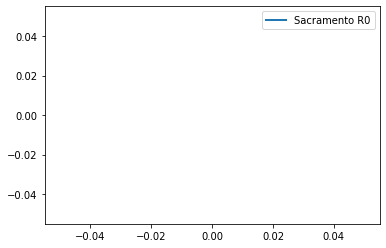

In [81]:
x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

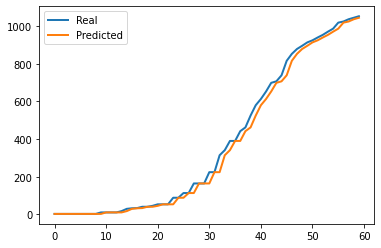

In [82]:
pred_vals = []
for i in range(79-19):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(60)
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

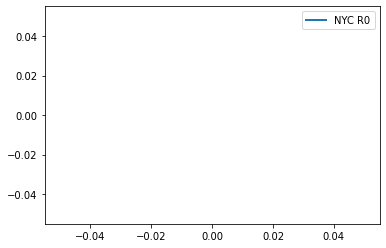

In [83]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

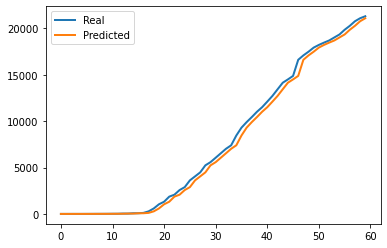

In [84]:
pred_vals_NYC = []
for i in range(79-19):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(60)
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()